# 01_summary_statistics.ipynb

In [1]:
import contextily as cx
import figure_utilities
import figure_and_table_constants
from stats_utilities import produce_summary_statistics
from panel_utilities import convert_weekly_panel_to_biweekly_panel
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import os
import pandas as pd

# Store paths.
INPUT_DATA_UNRESTRICTED = "../../data/03_cleaned/unrestricted_weekly.parquet"
INPUT_DATA_RESTRICTED = "../../data/03_cleaned/crime_analysis_weekly.parquet"
OUTPUT_TABLES = "../../output/summary_statistics/tables"
OUTPUT_FIGURES = "../../output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_parquet(INPUT_DATA_UNRESTRICTED)

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

# So we can use 'case_number' like a column
unrestricted_df = unrestricted_df.reset_index()

# Restrict to Boston evictions.
boston_mask = ((unrestricted_df['County'] == "Suffolk County") & (~unrestricted_df['City'].isin(["Chelsea", "Revere", "Winthrop"])))
unrestricted_df = unrestricted_df.loc[boston_mask, :]

/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_21319/1338694823.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from 

ConnectionError: HTTPSConnectionPool(host='stamen-tiles-a.a.ssl.fastly.net', port=443): Max retries exceeded with url: /toner-lite/13/2476/3028.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fc28a2363d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

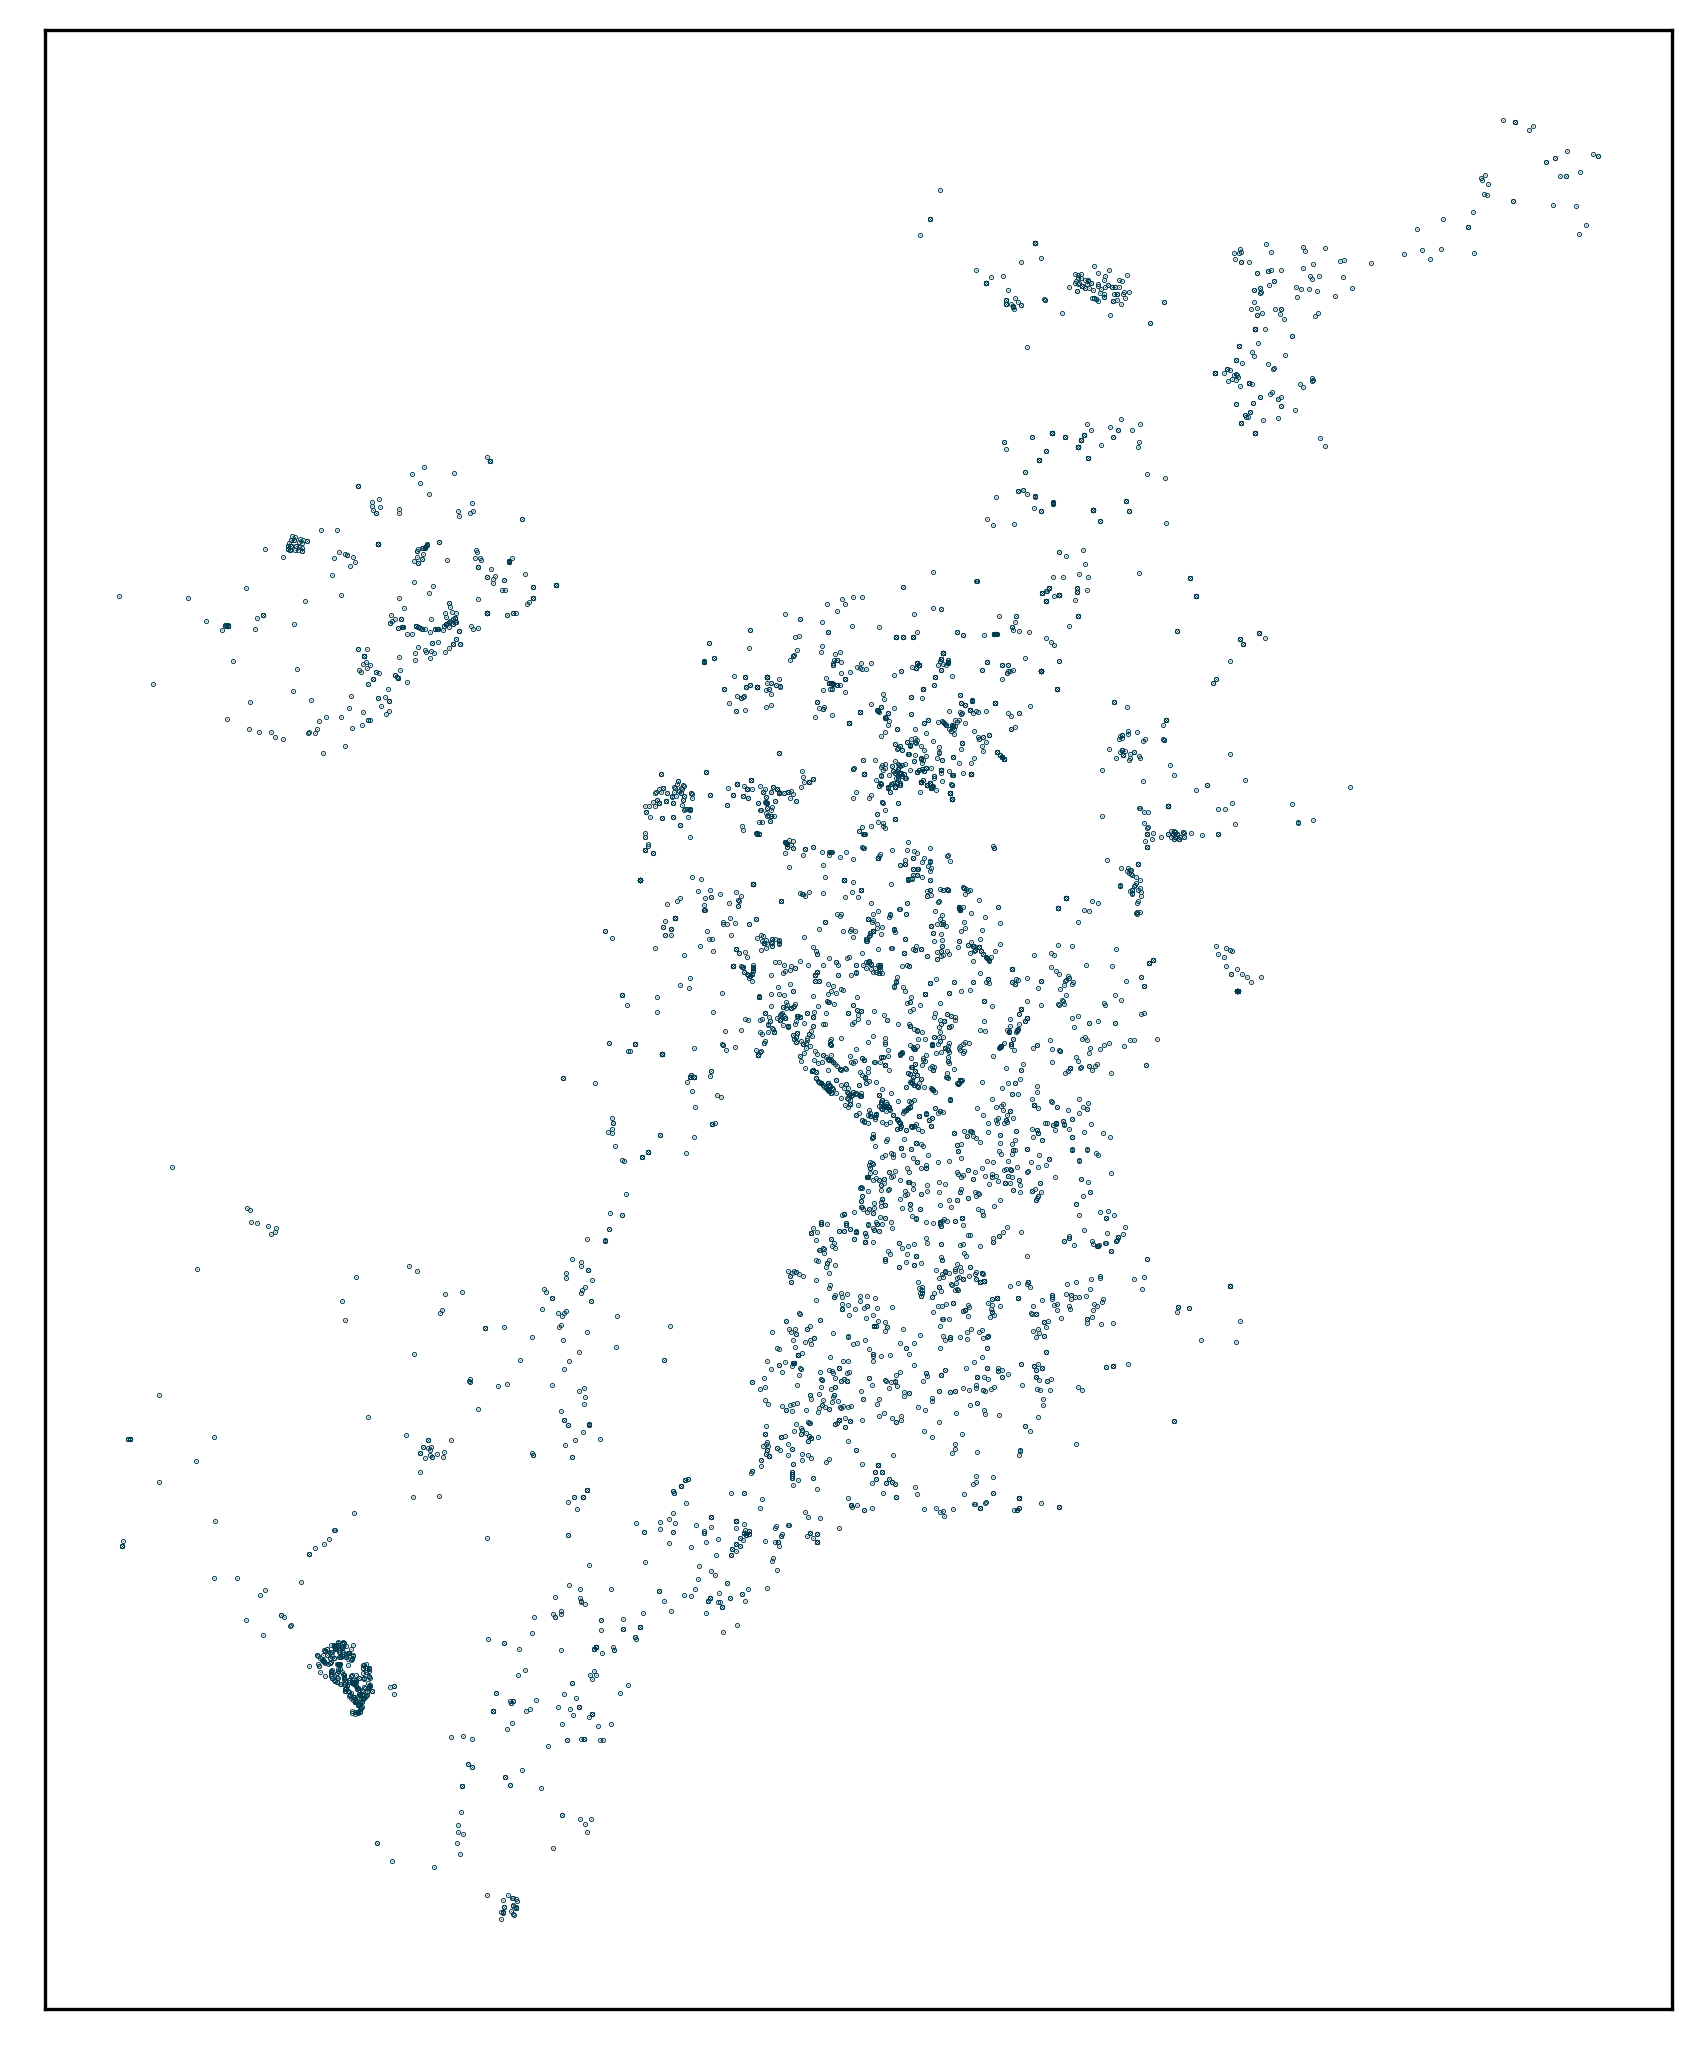

In [2]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color=figure_and_table_constants.Colors.P3,
                      markersize=0.05)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

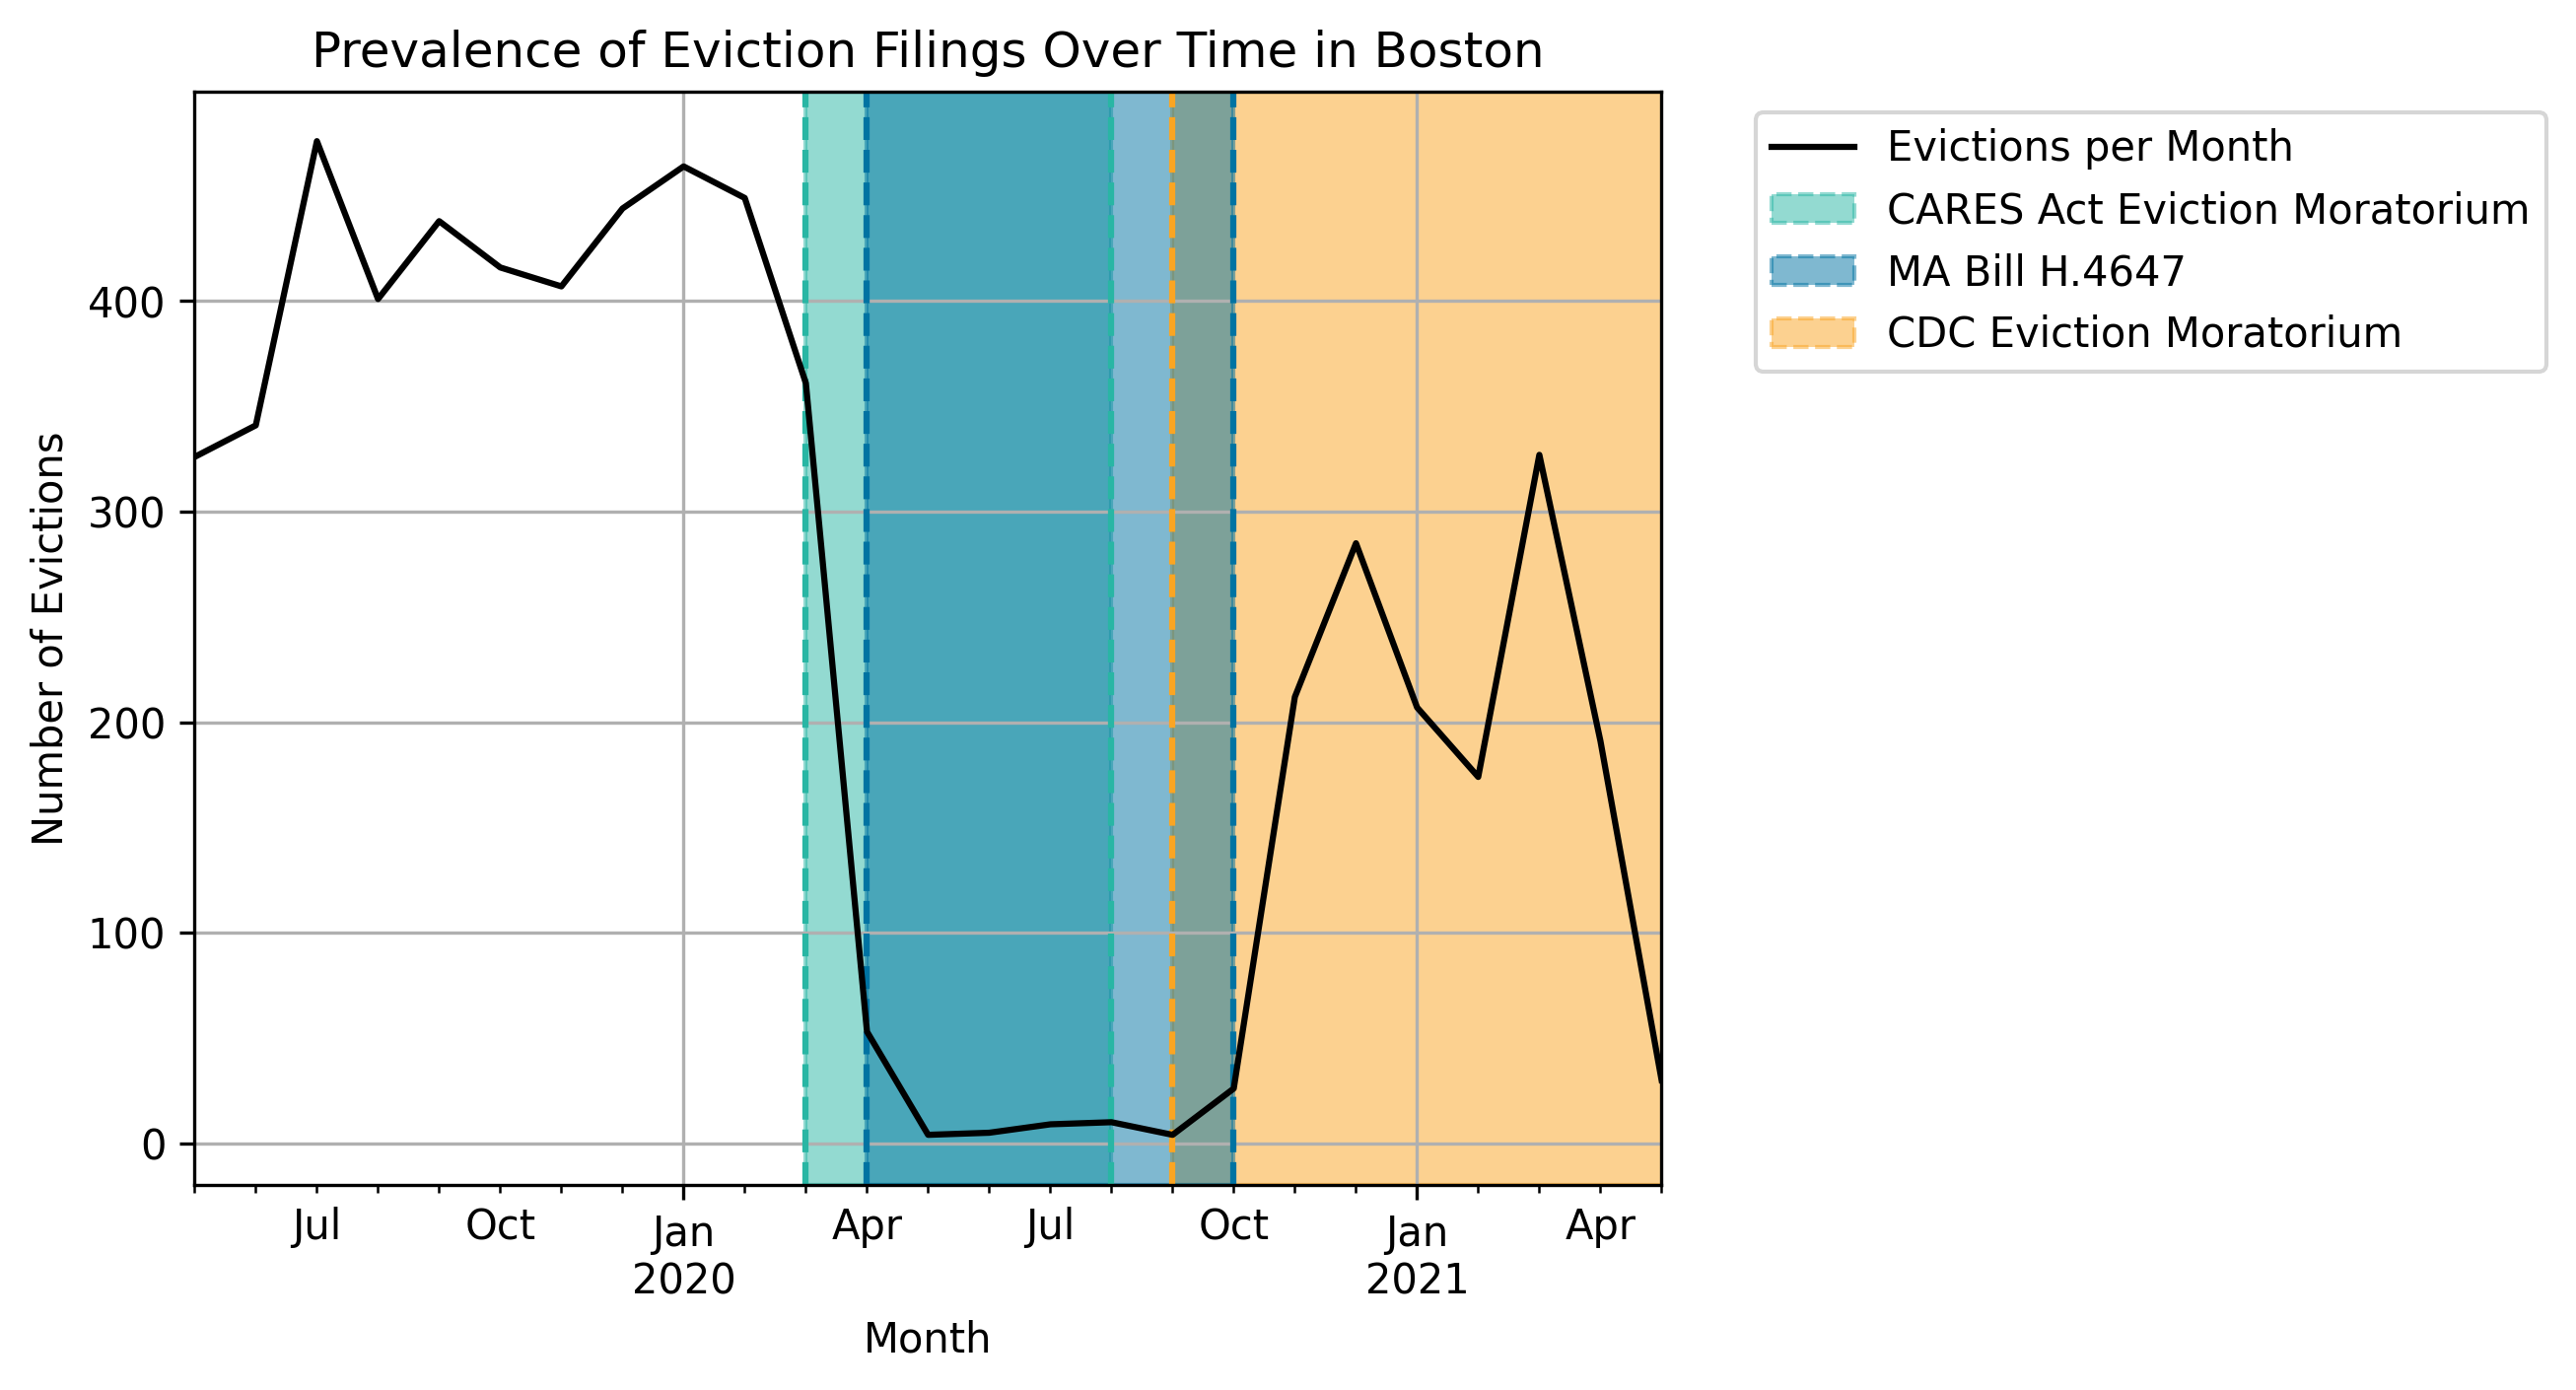

In [2]:
# Plot the number of eviction filings over time.
unrestricted_df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(unrestricted_df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = unrestricted_df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_title("Prevalence of Eviction Filings Over Time in Boston")
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
                   Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
                         alpha=0.5, linestyle='--'),
                   Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
                         linestyle='--'),
                   Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
                         linestyle='--')]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [3]:
# Produce summary statistics for unrestricted sample.
unrestricted_df = convert_weekly_panel_to_biweekly_panel(unrestricted_df, ['group_0_crimes_100m',
                                                 'group_1_crimes_100m',
                                                 'group_2_crimes_100m'])
treatment_date_variable = 'file_date'
summary_statistics_unrestricted, variable_display_names_dict  = produce_summary_statistics(unrestricted_df,
                                                                                           treatment_date_variable=treatment_date_variable)

# Rename rows.
variable_names = summary_statistics_unrestricted.index.get_level_values(1)
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(index=variable_display_names_dict)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(columns=column_display_names_dict)
summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

Mean  \
Panel                                            Variable                                                          
Panel A: Pre-treatment Outcomes                  pre_treatment_change_in_group_0_crimes_100m           -0.300330   
                                                 pre_treatment_change_in_group_1_crimes_100m            0.017987   
                                                 pre_treatment_change_in_group_2_crimes_100m            0.025578   
                                                 twenty_seventeen_group_0_crimes_100m                   2.315182   
                                                 twenty_seventeen_group_1_crimes_100m                   0.173432   
                                                 twenty_seventeen_group_2_crimes_100m                   0.186469   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                     0.314502   
                                                 job_density_2013                                   14806.080670   
                                                 med_hhinc2016                                      47188.865842   
                                                 poor_share2010                                         0.276043   
                                                 popdensity2010                                     22704.519672   
Panel C: Case Initiation                         for_cause                                              0.166172   
                                                 no_cause                                               0.053135   
                                                 non_payment                                            0.777558   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                               0.077228   
                                                 hasAttyP                                               0.882508   
                                                 isEntityD                                              0.018812   
                                                 isEntityP                                              0.811221   
Panel E: Case Resolution                         case_duration                                         58.165636   
                                                 defaulted                                              0.193234   
                                                 dismissed                                              0.266337   
                                                 heard                                                  0.029208   
                                                 judgment                                            1938.569408   
                                                 mediated                                               0.402475   
Panel F: Post-treatment Outcomes                 group_0_crimes_100m_1_years_relative_to_treatment      1.457716   
                                                 group_0_crimes_100m_2_years_relative_to_treatment      1.476678   
                                                 group_1_crimes_100m_1_years_relative_to_treatment      0.139849   
                                                 group_1_crimes_100m_2_years_relative_to_treatment      0.104240   
                                                 group_2_crimes_100m_1_years_relative_to_treatment      0.202040   
                                                 group_2_crimes_100m_2_years_relative_to_treatment      0.220495   

                                                                                                          Median  \
Panel                                            Variable                                                          
Panel A: Pre-treatment Outcomes                  pre_treatment_change_in_group_0_crimes_100m            0.000000   
                                               

In [8]:
# Load restricted data.
restricted_df = pd.read_parquet(INPUT_DATA_RESTRICTED).reset_index()

In [9]:
treatment_timings = (restricted_df
                     .groupby(['file_month', 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
print(treatment_timings)
treatment_timings = treatment_timings.pivot(index='file_month', columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(restricted_df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Filing Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Filing Month")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                          'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings

   file_month  judgment_for_plaintiff  case_number
0     2019-05                       0           68
1     2019-05                       1          102
2     2019-06                       0           66
3     2019-06                       1          119
4     2019-07                       0           69
5     2019-07                       1          179
6     2019-08                       0           55
7     2019-08                       1          144
8     2019-09                       0           64
9     2019-09                       1          138
10    2019-10                       0           93
11    2019-10                       1           95
12    2019-11                       0           44
13    2019-11                       1          119
14    2019-12                       0           76
15    2019-12                       1          157
16    2020-01                       0           87
17    2020-01                       1          171
18    2020-02                  

,Cases Won By Defendant,Cases Won By Plaintiff,Portion of All Cases
Filing Month,,,
All Filing Months,1541.0,1906.0,1.000000
2019-05,68.0,102.0,0.049318
2019-06,66.0,119.0,0.053670
2019-07,69.0,179.0,0.071947
2019-08,55.0,144.0,0.057731
2019-09,64.0,138.0,0.058602
2019-10,93.0,95.0,0.054540
2019-11,44.0,119.0,0.047287
2019-12,76.0,157.0,0.067595
